<a href="https://colab.research.google.com/github/JessicaFabiano/Analise-Titanic/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Previsão de Sobrevivência no Titanic**

O objetivo deste modelo de Machine Learning é prever a sobrevivência de passageiros no Titanic. O foco é realizar a limpeza dos dados, criar novas variáveis e treinar modelo de Classificação.

In [22]:
# Importação da Biblioteca e Carregamento dos Dados
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [23]:
# Validando as primeiras 5 linhas
display (train.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Análise Exploratória Inicial**

Verificando quais colunas possuímos, os tipos de dados e se existem valores nulos (dados faltantes) que precisarão ser tratados mais à frente.

In [24]:
# Verificando informações básicas
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


**Levantamento de Hipóteses**

Historicamente, sabemos que a regra ''mulheres e crianças primeiro'' foi aplicado no naugráfio. Entao, irei verificar nos dados se o gênero e a classe econômica (Pclass) realmente impactaram nas chances de sobrevivência.

In [25]:
# Taxa de sobrevivência por 'Sex'
print (train[['Sex', 'Survived']].groupby(['Sex']).mean())

        Survived
Sex             
female  0.742038
male    0.188908


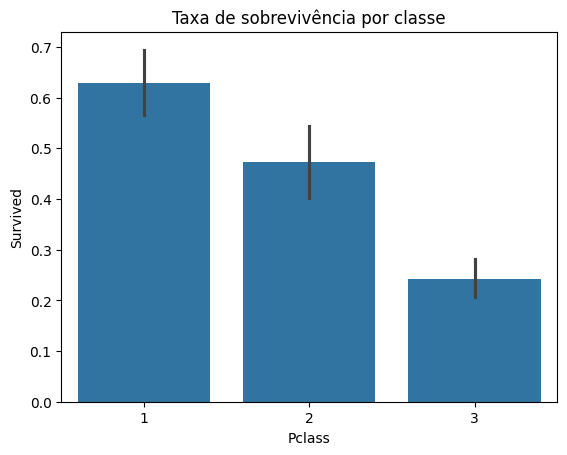

In [26]:
# Validando se a classe econ6omica influenciou na chance de chegar ao bote
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Taxa de sobrevivência por classe')
plt.show()

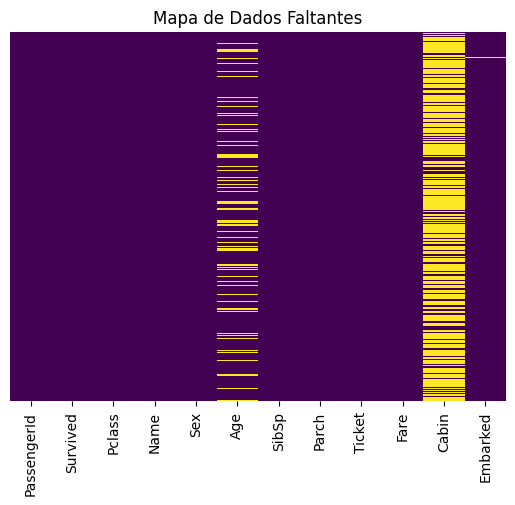

In [27]:
# Mapa de Calor de valores nulos
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Mapa de Dados Faltantes')
plt.show()

**Feature Engineering e Limpeza de Dados**

Ao invés de simplesmente preencher as idades faltantes com a média geral, podemos ser mais precisos. Por isso, optei por extrair os **Títulos** (Mr., Miss., Mrs., Master., etc) contidos nos nomes dos passageiros.

Como pessoas com o mesmo título tendem a ter idades semelhantes (um 'Master' é geralmente um menino, enquanto um 'Mr.' é um homem adulto), usei a mediana de idade de cada título para preencher os valores nulos da coluna 'Age'.

In [28]:
# Criando a coluna 'Title' (Título) extraindo o padrão de texto dos nomes
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [29]:
# Validando o que foi encontrado
print(train['Title'].value_counts())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


In [31]:
# Substituindo títulos raros por uma categoria única chamada ''Rare''
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

# Corrigindo abreviaçoes (Mlle e Ms são o mesmo que Miss)
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

# Validando novamente
print(train['Title'].value_counts())

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


In [32]:
# Preechendo os nulos da Idade com a mediana da Idade do Grupo (title)
train['Age'] = train['Age'].fillna(train.groupby('Title')['Age'].transform('median'))

# Conferindo se ainda possui idades vazias
print('Idades sobrando vazias:', train['Age'].isnull().sum())

Idades sobrando vazias: 0


**Transformação de Variáveis Categóricas**

Modelos de Machine Learning não lidam bem com textos. Por este motivo, é necessário transformar variáveis categóricas (como Sexo, Título e Porto de Embarque) em valores numéricos.

In [33]:
# Mapeando Masculino para 0 e Femninino para 1
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})

In [34]:
# Mapeando os títulos
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
train['Title'] = train['Title'].map(title_mapping)

In [35]:
# Preenchendo os 2 nulos com 'S' (Southampton), que é o porto onde a maioria embarcou
train['Embarked'] = train['Embarked'].fillna('S')

# Mapeando para números
train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q':2})

In [36]:
# Preenchendo idades vazias com a mediana de cada Título
train['Age'] = train['Age'].fillna(train.groupby('Title')['Age'].transform('median'))

In [37]:
# Lista de colunas que vamos descartar
colunas_para_remover = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# Removendo as colunas
train = train.drop(colunas_para_remover, axis=1)

# Conferindo como ficou o dataset final
print(train.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title
0         0       3    0  22.0      1      0   7.2500         0      0
1         1       1    1  38.0      1      0  71.2833         1      2
2         1       3    1  26.0      0      0   7.9250         0      1
3         1       1    1  35.0      1      0  53.1000         0      2
4         0       3    0  35.0      0      0   8.0500         0      0


**Preparação para a Modelagem**

Com os dados limpos, irei descartar as colunas que não ajudam na previsão (como nome, ID e número do ticket). Em seguida, separei o conjunto de dados entre 'X' (variáveis preditivas) e 'y' (variável alvo: Sobreviveu ou não).

In [38]:
# A resposta que quero prever
y = train['Survived']

# As perguntas que vou usar (tudo menos a resposta)
X = train.drop('Survived' , axis=1)

**Treinando o Modelo**

Para este caso de classificação, utilizei o **Random Forest Classifier** (Floresta Aleatória). É um modelo robusto, que lida bem com relações não lineares e permite entender quais variáveis foram mais importantes para a decisão.

In [39]:
# Treinando o modelo
from sklearn.ensemble import RandomForestClassifier

# Criando a floresta com 100 árvores
modelo = RandomForestClassifier(n_estimators=100, random_state=42)

modelo.fit(X, y)

# Verificando a acurácia inicial do treino
print(f'Acurácia do modelo: {round(modelo.score(X, y) * 100, 2)}%')

Acurácia do modelo: 98.09%


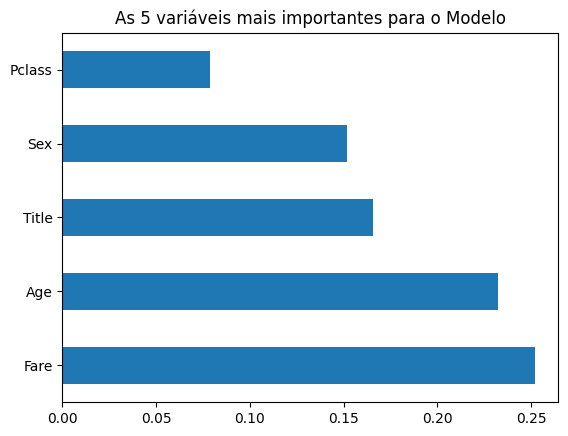

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Criando um gráfico com a importância de cada coluna
importancias = pd.Series(modelo.feature_importances_,index=X.columns)
importancias.nlargest(5).plot(kind='barh')
plt.title('As 5 variáveis mais importantes para o Modelo')
plt.show()

In [41]:
# Extraindo Titulos
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+) \.', expand=False)

In [42]:
# Agrupando Títulos
test['Title'] = test['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare').infer_objects(copy=False)
test['Title'] = test['Title'].replace(['Mlle', 'Ms'], 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

/tmp/ipython-input-2896039459.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Title'] = test['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare').infer_objects(copy=False)


In [43]:
# Mapeando para Números
test['Title'] = test['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})
test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [44]:
# Preenchendo nulos (Idade e Tarifa)
test['Age'] = test['Age'].fillna(test.groupby('Title')['Age'].transform('median'))
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [45]:
# Removendo colunas desnecessárias (guardando o ID para o resultado final)
passenger_ids = test['PassengerId']
test_limpo = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [46]:
previsoes = modelo.predict(test_limpo)
resultado = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': previsoes})

# Salvando em CSV
resultado.to_csv('meu_resultado_titanic.csv', index=False)
print('Previsões salvas com sucesso!')

Previsões salvas com sucesso!


**Previsão nos Dados de Teste e Conclusão**

Apliquei as mesmas transformações nos dados de teste inéditos, gerei as previsões e salvei o arquivo final para submissão. Abaixo, visualizamos a proporção final de sobreviventes prevista pelo modelo.

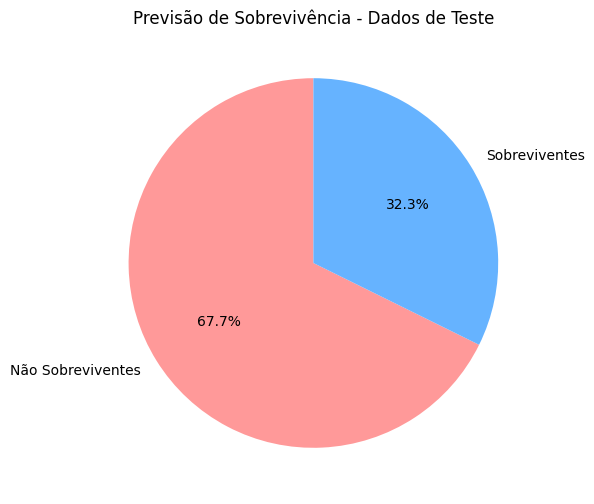

In [47]:
from numpy._core.defchararray import title
from matplotlib import figure
import matplotlib.pyplot as plt

contagem = resultado['Survived'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(contagem, labels=['Não Sobreviventes', 'Sobreviventes'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], startangle=90)
plt.title('Previsão de Sobrevivência - Dados de Teste')
plt.show()